# **Tutorial:** Dimensionality reduction & neural population models: static

[slides](https://docs.google.com/presentation/d/e/2PACX-1vSe2j2ewT0oycRirE2zeMBoFvUZp47ozIno4h5Zd0VhJRv-9k5mp86TJ7V4XsFOBm-e6wluv9WNjGT2/pub?start=false&loop=false&delayms=3000)

We will learn how to:
* visualize and perform exploration analysis on neuronal population data
* apply principle component analysis (PCA)
* understand the relationship between the PCA on the trial-to-trial variability in responses vs. the network connectivity

## Setups

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets  # interactive display
from numpy.linalg import eig, eigh
import imageio.v2 as imageio
from tqdm.notebook import tqdm
import IPython
from IPython.display import Image
import os

from matplotlib import rcParams

rcParams.update({"font.size": 18})

# %load_ext lab_black

In [ ]:
def make_a_scene(dffs, roi_mask_list):
    scene = np.zeros(roi_mask_list[0].shape, dtype="float")
    for dff, roi in zip(dffs, roi_mask_list):
        scene += roi * dff
    return scene


def make_a_gif(title, gif_filename, data, rois, vmin=0, vmax=1):
    """
    A function that makes a *.gif animation of neuronal population activity
    Parameters
    ----------
    title: title to be displayed on the video
    gif_filename: filename for saving the gif
    data: neuronal data [trials x neurons]
    rois: binary roi masks for the field-of-view simulation (data from Allen Brain) [neurons, 512px x 512px]
    vmin: min value (black)
    vmax: max value (white)
    """
    assert gif_filename[-4:] == ".gif"
    with imageio.get_writer(gif_filename, mode="I") as writer:
        for frame in tqdm(data):
            scene = make_a_scene(frame, rois)

            fig = plt.figure()
            plt.imshow(scene, cmap="gray", vmin=vmin, vmax=vmax)
            plt.axis("off")
            plt.title(title)
            # label the neurons
            for i, roi in enumerate(rois):
                cm = np.array(np.where(roi)).mean(-1)[::-1]
                cm[0] += 10  # move right
                plt.text(*cm, i, color="white")
            filename = f"scene_{gif_filename[:-4]}.jpg"
            fig.savefig(filename)
            plt.close()
            image = imageio.imread(filename)
            writer.append_data(image)

In [ ]:
lambdas = np.array([1, 0.8, 0.5]).reshape((-1, 1))  # shared noise spectrum
n = len(lambdas)  # shared (latent) noise dimension
T = 3000  # recorded datapoints


def set_true_ensambles(random_seed=0, N=20):
    np.random.seed(random_seed)
    C = np.clip(np.random.randn(N, n) ** 11, -1, 1)  # latent space projection
    return C


def generate_data(C, random_seed=0, N=20):
    # generate synthetic data
    np.random.seed(random_seed)
    eps = np.random.randn(n, T) * lambdas  # shared (latent) noise
    dx = 0.25 * np.random.randn(N, T)  # private single-neuron noise
    fr = 3 * (np.random.rand(N).reshape((-1, 1)) + 1)  # avg fr in Hz
    dfr = np.random.rand(N).reshape((-1, 1)) * 1  # fr changes in Hz
    z = C @ eps + dx
    x = z * dfr + fr

    return x.T


# set rois
all_rois = np.load("rois.npy")
np.random.seed(15)  # a seed that looks nice
rois = all_rois[np.random.choice(np.arange(len(all_rois)), 20)]

# set true ensambles
C = set_true_ensambles()

# generate and visualize the data
X = generate_data(C)

assert np.all(X > 0)

# if demo gif is not created -- create
if not os.path.exists("0_raw_fr.gif"):
    make_a_gif("Raw responses", "0_raw_fr.gif", X[: T // 10], rois, vmin=0, vmax=5)

In [ ]:
def descending_eigh(cov):
    w, v = eigh(cov)

    # reorder in descending eigenvalue order
    sort = np.argsort(w)[::-1]
    w, v = w[sort], v[:, sort]

    return (w, v)

## Exploratory data analysis

The first step of the analysis, when you get a new dataset, is to **visualize** what is in it. Let us start with a field-of-view video of neuronal activity (*note, this data resembles real, but it is not real; it was simulated for the sake of simplicity in this tutorial*)

In [ ]:
Image(filename="0_raw_fr.gif")  # a simulated field-of-view recording for our dataset

Here we got our hands on a relatively small recording of neuronal activity in the visual cortex in response to a presentation of a stimulus (e.g. a picture of a Table Mountain). The responses were characterized by the average firing rate of each neuron in response to the stimulus and stored in the dataset $X$.
The dimensionality of the dataset $X$ is $[\mathrm{trials} \times \mathrm{neurons}]$

In [ ]:
n_trials, n_neurons = X.shape
(n_trials, n_neurons)

(3000, 20)

Note, that our simulated responses are non-negative. It is a common property both for the firing rate and the $\Delta F/F$ (with a properly subtracted baseline). Let's double-check that:

In [ ]:
np.all(X > 0)

True

We can also 'forget' about the locations of the neurons in the virtual field-of-view and visualize the data as it is, using a 2D raster plot:

In [ ]:
plt.figure(figsize=(20, 4))
plt.imshow(X[: T // 10].T, vmin=0, aspect=5, interpolation="None", cmap="inferno")
plt.title("Trial-average responses of the neuronal population")
plt.xlabel("trial #")
plt.ylabel("neuron #")
plt.colorbar(aspect=10, pad=0.02, label="avg. firing rate, Hz")
# help(plt.colorbar)

### **Think!**

Is there any structure in the data? What does it tell us? Which neurons do you think work together?

Why do we see that rows on average have different colors?

1. There is some structure in those reponses... some rows in the 2D raster look similar, meaning that the neurons work together in sync!

2. **But**, we also see that rows on average have very different colors, meaning that the firing rates of the neurons are drastically different

## Focus on trial-to-trial variability

It is hard to tell what each neuron is doing from the visualizations above.

The reason for that is the variability in the individual properties of single neurons: their *mean* firing rates and the *trial-to-trial variability* in the single neuron responses.


### Exercise 1a: Calculate mean and std of the firing rate 
*Hint: think about the axes in the data. Which one is the sample-axis, and which one is the feature-axis?*

*Hint2: what dimensionality do we expect to see in the correct answer?*

In [ ]:
# TODO: calculate mean and std of firing rates
# hint: think about the dimensions of the data X and the dimension of the vector of neuronal firing rates
mean_fr = ...
std_fr = ...

sort = np.argsort(
    mean_fr
)  # the ordering that sorts neuons according to their firing rate
plt.errorbar(range(len(mean_fr)), mean_fr[sort], yerr=std_fr[sort], capsize=5)
plt.title("Firing rates across the neuronal population")
plt.xlabel("neuron # (sorted by firing rate)")
plt.ylabel("firing rate, Hz")

Remember, in this tutorial we are interested in the **neuronal population**: how individual neurons talk to each other and collectively process information.

Let us remove it by z-scoring the responses. *Z-scoring means subtracting the mean and dividing by the standard deviation (which we already calculated above).*

### Exercise 1b: Z-score the data

In [ ]:
# TODO: Z-score the data
Z_scored_X = ...

if not os.path.exists("1_z-scored.gif"):
    make_a_gif(
        "Z-scored responses",
        "1_z-scored.gif",
        Z_scored_X[: T // 10],  # visualizing first 10% of the data
        rois,
        vmin=-1,
        vmax=1,
    )
Image(filename="1_z-scored.gif")

In [ ]:
plt.figure(figsize=(20, 4))
plt.imshow(
    Z_scored_X[: T // 10].T,
    vmin=-1,
    vmax=1,
    aspect=5,
    interpolation="None",
    cmap="inferno",
)
plt.title("Trial-to-trial variability in responses of the neuronal population")
plt.xlabel("trial #")
plt.ylabel("neuron #")
plt.yticks(np.arange(0, n_neurons, 2))
plt.colorbar(aspect=10, pad=0.02, label="z-scored response")
# help(plt.colorbar)

### **Think!**

Based on the video and 2D raster plot above, can you tell which neurons might be working together?

### Exercise 2: Find neurons that work in sync
Inform your guess based on the above visualization of the trial-to-trial variability.

In [ ]:
# TODO: Pick the neurons that you think fire together
n1, n2 = ... , ....
data_pair = X[:, [n1, n2]]  # taking a subset of 2 neurons from the population recording
plt.scatter(*data_pair.T, alpha=0.2)
plt.xlabel(f"activity of neuron #{n1}, Hz")
plt.ylabel(f"activity of neuron #{n2}, Hz")

If you indeed selected a *correlated* pair of neurons (such as #0 and #2), you would see that whenever the activity of the first one is high (low), the activity of the other one is also high (low). They generally tend to fire together!

## Describing joint neuronal activity with a multivariate Gaussian


The joint distribution of activity of these 2 neurons resemble a multivariate Gaussian, which typically looks like this:
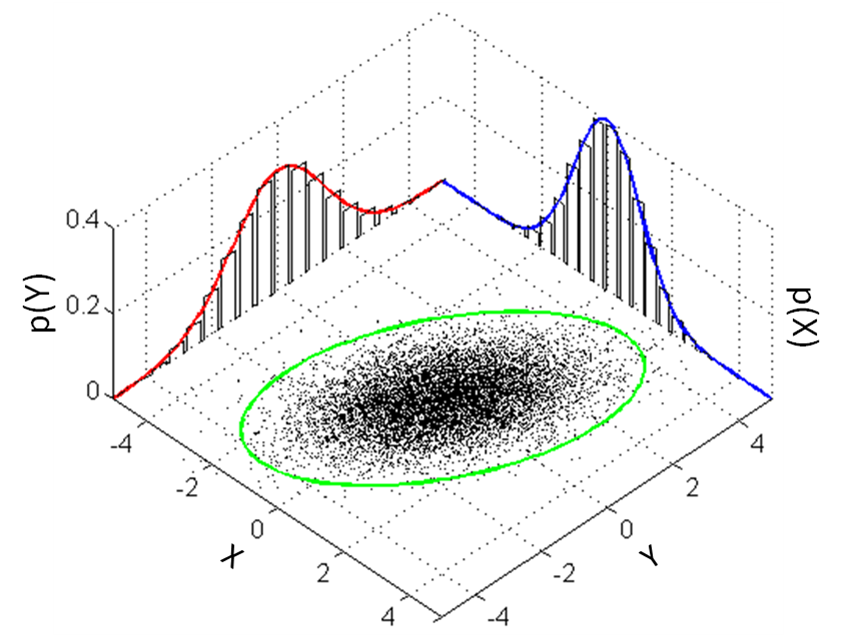


A multivariate N-dimensional Gaussian is characterized by 2 sets of parameters:
* the mean $\mathbf{\mu}$ (a $[N]$-dimensional vector)
* the covariance $\Sigma$ (an $[N \times N]$ matrix)

One of the simplest ways to fit the Gaussian distribution to the data is *via* so-called **moment-matching**: calculating means, variances and co-variances of the datapoints.

First we'll calculate the mean $\mathbf{\mu} = \mathop{\mathbb{E}}\mathbf{x} = \sum_{i=1}^{n_\mathrm{trials}} \mathbf{x}_i \, /\, n_\mathrm{trials} $ (a 2D *population* vector for 2 neurons)

*Notation:* The variables in **bold** here correspond to vectors, e.g. here $\mathbf{x} = (x_1,x_2)^T$. Additionally, $\mathbf{x}_i$ above corresponds to population activity vector recorded in trial $i$.

# WHITEBOARD recap of eigenvalue decomposition

### Eigenvectors and eigenvalues (**skip during the tutorial**, that is for revising later if needed)

What we did above in fact corresponds to the eigendecomposition.
For more info check Chris's tutorial [Appendix](https://colab.research.google.com/drive/1AH5_d_uJTnJMUANGt9XIIkkg8n2Tur4s).

The key points that we need from this Appendix:

Eigendecomposition of a matrix is a type of decomposition that involves decomposing a **square** ($n \times n$) matrix into a **set** of *eigenvectors* and *eigenvalues*.

A vector $\rm{x}$ is an eigenvector of a matrix $A$ if it satisfies the following equation.

$A\rm{x} = \lambda \rm{x} \tag{E.1}$

This is called the eigenvalue equation, where $A$ is the parent square matrix that we are decomposing, $x$ is the eigenvector of the matrix, and $\lambda$ is the lowercase Greek letter lambda and represents the eigenvalue scalar.

This can also be rearranged into

$(A-\lambda I)\rm{x} = 0 \tag{E.2}$

Where $I$ is the square identity matrix ($1$s in its main diagonal and $0$s in every other entry) with the same dimensions as $A$. 

In order to determine the all eigenvectors of a matrix, you must first determine the eigenvalues. 

Non-trivial solutions exist only if the matrix ($A-\lambda I$) is singular which means $\det(A-\lambda I) = 0$. Where $\det(M)$ or $|M|$ is the [determinant](https://en.wikipedia.org/wiki/Determinant) of the matrix.

Therefore eigenvalues of $A$ are roots of the [characteristic polynomial](https://en.wikipedia.org/wiki/Characteristic_polynomial)

$p(\lambda) = \det(A-\lambda I) \tag{E.3}$

#### **Think!**

What is the order of the polynomial for a 2D matrix $A$? How many roots will it have?

### Exercise 3a: Compute mean responses for each neuron

In [ ]:
# TODO: compute mean responses for a pair of neurons
mu = ...
mu

### Exercise 3b: Compute the covariance between activities of these neurons

Next, we calculate the covariance matrix for these neurons $\Sigma = \mathop{\mathbb{E}} (\mathbf{x}-\mathbf{\mu})^2 = \sum_{i=1}^n (\mathbf{x}_i - \mathbf{\mu})^T(\mathbf{x}_i - \mathbf{\mu})\, /\, n_\mathrm{trials}$

In [ ]:
x_centered = data_pair - mu
# TODO: compute sample covariance for a pair of neurons
cov = x_centered.T @ x_centered / n_trials  
cov

*Note: since we removed the stimulus-related mean responses ('stimulus correlation'), only trial-to-trial variability is left. These correlations between trial-to-trial difference in neuronal responses are called 'noise correlations'. Noise correlations give us a hint of what the neuronal connectivity can be, as we will see at the end of the tutorial.* 

## Change the basis from (neuron 0, neuron 1) -> eigenvector 0-1

In [ ]:
(𝜆, v) = descending_eigh(cov)  
(𝜆, v)

In [ ]:
plt.figure(figsize=(5, 5))
plt.scatter(*x_centered.T, alpha=0.2)  
plt.arrow(
    0,
    0,
    *(v[:, 0]),
    color="#FF1122",
    linewidth=2,
    label="First eigenvector (high eigenvalue)"
)
plt.arrow(0, 0, *(v[:, 1]), color="#11FFAA", linewidth=2, label="Second eigenvector")
plt.xlabel("activity of neuron #0 (centered)")
plt.ylabel("activity of neuron #1 (centered)")
plt.title("Eigenvectors of the covariance matrix")
r = 2  # plot range
plt.xlim([-r, r])
plt.ylim([-r, r])
plt.legend(loc=(1.1, 0))

*Note,* that the eigenvectors of the covariance matrix always form an **orthonormal basis** (due to the symmetry of the covariance matrix). We can double-check that:

In [ ]:
print("Is the dot product of eigenvectors = 0 ?")
np.allclose(np.dot(v[:, 0], v[:, 1]), 0)

## Projecting the activity on eigenvectors

### **Exercise 4.** Project the activity of pair of neurons on the eigenvectors

In [ ]:
plt.figure(figsize=(5, 5))
# TODO: project the centered activity x_centered on the eigenvectors
x_projected = ...

plt.scatter(*x_projected.T, alpha=0.2)
plt.arrow(
    0,
    0,
    1,
    0,
    color="#FF1122",
    linewidth=2,
    label="First eigenvector (high eigenvalue)",
)
plt.arrow(0, 0, 0, 1, color="#11FFAA", linewidth=2, label="Second eigenvector")
plt.xlabel("eigenvector #0")
plt.ylabel("eigenvector #1")
plt.title("Neuronal activity in the eigenvector basis")
r = 2  # plot range
plt.xlim([-r, r])
plt.ylim([-r, r])
plt.legend(loc=(1.1, 0))

### **Think!**

Suppose we want to reduce the dimensionality of this data from 2D -> 1D. Which direction is the most informative about the activity of both neurons?

# Principle component analysis (PCA)

## Step-by-step

Let us return to our larger, 20D z-scored dataset:

In [ ]:
plt.figure(figsize=(20, 4))
plt.imshow(
    Z_scored_X[: T // 10].T,
    vmin=-1,
    vmax=1,
    aspect=5,
    interpolation="None",
    cmap="inferno",
)
plt.title("Trial-to-trial variability in responses of the neuronal population")
plt.xlabel("trial #")
plt.ylabel("neuron #")
plt.yticks(np.arange(n_neurons))
plt.colorbar(aspect=10, pad=0.02, label="z-scored response")
# help(plt.colorbar)

### **Exercise 5** Compute the sample covariance for a larger population (20D)

Next, we calculate the sample covariance matrix for these neurons $\Sigma = \mathop{\mathbb{E}} (\mathbf{x}-\mathbf{\mu})^2 = \sum_{i=1}^n (\mathbf{x}_i - \mathbf{\mu})^T(\mathbf{x}_i - \mathbf{\mu})\, /\, n_\mathrm{trials}$

Note, that if we use the *z-scored* data, we automatically obtain the *correlation* matrix, which then coincides with the covariance. By definition, the *correlation* matrix is:

$\rho_{jk} = \cfrac{\sum_i^{n_\mathrm{trials}}(x_{ij} - \mu_{ij})^T(x_{ik} - \mu_{ik})}{\sigma_j \sigma_k} $

Since $\sigma_j=1$ for every neuron after z-scoring, the *correlation* matrix here coincides with the *covariance*.

In [ ]:
# Calculate sample covariance
cov = ...

plt.imshow(cov)

In [ ]:
𝜆, v = descending_eigh(cov)

plt.figure(figsize=(4, 2))
plt.plot(𝜆)
plt.scatter(np.arange(len(𝜆)), 𝜆)
plt.title("Scree plot (eigenspectrum)")  # TODO: check notation
plt.xlabel("# component")
plt.ylabel("eigenvalue")

## From eigenvalues to variance explained

Sample covariance in the eigenvector basis assumes a simple form ($\Sigma_0$ -- diagonal matrix):

$$
\newcommand{\vertbar}{\rule[-1ex]{0.5pt}{2.5ex}}
\newcommand{\horzbar}{\rule[.5ex]{2.5ex}{0.5pt}}
\Sigma 
= 
\begin{bmatrix}
    \horzbar & v_0 & \horzbar \\
    \horzbar & v_1 & \horzbar \\
    \horzbar & v_2 & \horzbar
\end{bmatrix} 
\underbrace{\begin{bmatrix}
    \lambda_0 & 0 & 0 \\
    0 & \lambda_1 & 0 \\
    0 & 0 & \lambda_2
\end{bmatrix}}_{\Sigma_0} 
\begin{bmatrix}
    \vertbar & \vertbar & \vertbar \\
    v_0 & v_1 & v_2 \\
    \vertbar & \vertbar & \vertbar
\end{bmatrix}
$$

In [ ]:
# checking that the above equation is indeed satisfied
np.allclose(cov, v @ (np.eye(len(𝜆)) * 𝜆) @ v.T)

From the form of $\Sigma_0$ (diagonal) we can see that there is no covariance between the components aligned with the eigenvectors.

### **Exercise 6a** Calculate the total variance of the data
Note: Both $\Sigma$ and $\Sigma_0$ must have the same total variance, since one is obtained from the other via an orthonormal transformation. But it is easier to see the answer in $\Sigma_0$

In [ ]:
# TODO: compute total variance (using 𝜆)
total_variance = ...

### **Exercise 6b** Calculate the variance in the first 3 PC components

In [ ]:
# TODO: compute variance in top-3 components (using 𝜆)
top_variance = ...

### **Exercise 6c** Plot variance explained as a function of the number of components

$\mathrm{fraction~of~variance~explained} = \cfrac{\mathrm{variance~in~top~components}}{\mathrm{total~variance}} = \cfrac{\sum_i^{n} \lambda_i}{\sum_i^{N} \lambda_i}$

In [ ]:
# make a vector of size [N] for variance in top components; hint: use cumsum
variance_in_top_components = ...

plt.plot(variance_in_top_components / total_variance)
plt.xlabel("# of components")
plt.ylabel("fraction of variance explained")
plt.title("")

## Identifying population vectors

In [ ]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(v[:, :3], vmin=-0.3, vmax=+0.3, cmap="RdBu")
ax[1].imshow(C, vmin=-1, vmax=+1, cmap="RdBu")

## **Exercise 7**: Using *sklearn*

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
# feed in [sample x features] data
pcs = pca.fit_transform(...) 
pcs.shape

In [ ]:
# eigenvalues
pca.singular_values_

In [ ]:
# variance explained
pca.explained_variance_ratio_

In [ ]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(pca.components_.T, vmin=-0.3, vmax=+0.3, cmap="RdBu")
ax[1].imshow(-C, vmin=-1, vmax=+1, cmap="RdBu")

# Conclusion

In this tutorial we:
* explored how to act when you encounter a new dataset (visualize! check a few neurons!)
* learned the ideas and math behind the principle component analysis (PCA)
* applied PCA (home-made and *sklearn*) and successfully reconstructed the network connectivity

Let us now take a break and then discuss the limitations of our analysis. When does it work? When does it not? Let's find out! 🐶